In [1]:
import numpy as np
import random
import math

### Value Class

In [2]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children) # Previous nodes
        self._op = _op # Operation that produced this node
        self.grad = 0.0
        self._backward = lambda: None
        self.label = label
    
    def __add__(self, other):
        other = Value(other) if isinstance(other, (int, float)) else other
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = Value(other) if isinstance(other, (int, float)) else other
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
    
        def _backward():
          self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
        out._backward = _backward
        return out
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + -other
    
    def __radd__(self, other):
        return self + other
    
    def __rsub__(self, other):
        return other + (-self)
    
    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1
    
    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out
    
    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"
    
    def backward(self):
        # Topological order of all childrens
        topo = []
        visited = set()
        def build_topo(node):
            if node not in visited:
                visited.add(node)
                for child in node._prev:
                    build_topo(child)
                topo.append(node)
                
        build_topo(self)
        
        self.grad = 1
        for v in reversed(topo):
            v._backward()

In [3]:
# brew install graphviz
# pip install graphviz
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

Value(data=-6.0, grad=0.0)


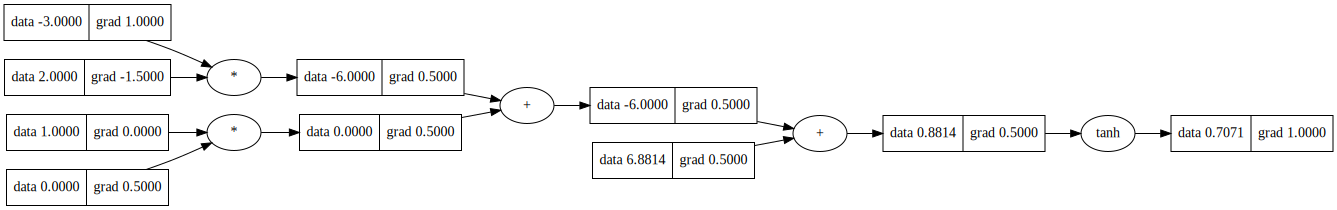

In [4]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
print(x1 * w1)
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
#e = (2*n).exp()
#o = (e - 1) / (e + 1)
o = n.tanh(); o.label = 'o'
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [5]:
import torch

In [6]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [7]:
class Module:

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []
    

In [8]:
class Neuron(Module):
    def __init__(self, input_dim, activation=True):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(input_dim)]
        self.b = Value(0.0)
        self.activation = activation
    
    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x))) + self.b
        act = act.relu() if self.activation else act
        return act
    
    def parameters(self):
        return self.w + [self.b]
    
    def __repr__(self):
        return f"{'RELU' if self.activation else 'Linear'}({len(self.w)})'"


In [9]:
class Layer(Neuron):
    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]
    
    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out
    
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]
    
    def __repr__(self):
        return f"Linear Layer({','.join([str(n) for n in self.neurons])})"

In [10]:
class MLP(Layer):
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], activation=i!=len(nouts)-1) for i in range(len(nouts))]
    
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
    def __repr__(self):
        return f"MLP({','.join(str(l) for l in self.layers)})"

In [11]:
nn = MLP(3, [4, 5, 6, 1])
print(nn)

MLP(Linear Layer(RELU(3)',RELU(3)',RELU(3)',RELU(3)'),Linear Layer(RELU(4)',RELU(4)',RELU(4)',RELU(4)',RELU(4)'),Linear Layer(RELU(5)',RELU(5)',RELU(5)',RELU(5)',RELU(5)',RELU(5)'),Linear Layer(Linear(6)'))


# Experiment

In [12]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
np.random.seed(454)
random.seed(454)

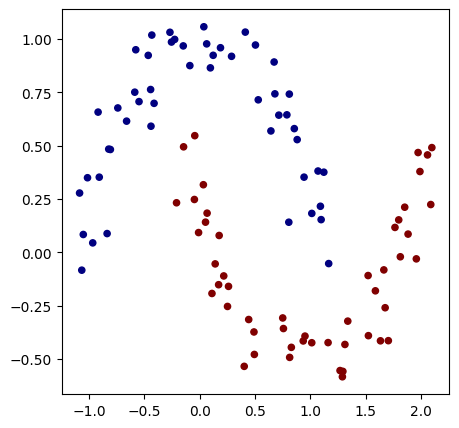

In [14]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [15]:
# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP(Linear Layer(RELU(2)',RELU(2)',RELU(2)',RELU(2)',RELU(2)',RELU(2)',RELU(2)',RELU(2)',RELU(2)',RELU(2)',RELU(2)',RELU(2)',RELU(2)',RELU(2)',RELU(2)',RELU(2)'),Linear Layer(RELU(16)',RELU(16)',RELU(16)',RELU(16)',RELU(16)',RELU(16)',RELU(16)',RELU(16)',RELU(16)',RELU(16)',RELU(16)',RELU(16)',RELU(16)',RELU(16)',RELU(16)',RELU(16)'),Linear Layer(Linear(16)'))
number of parameters 337


In [16]:
# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    #print(scores)
    #print(yb)
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=0.974591608489724, grad=0.0) 0.67


In [17]:
# optimization
for k in range(100):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 0.974591608489724, accuracy 67.0%
step 1 loss 0.5438547453663644, accuracy 81.0%
step 2 loss 0.5619830148501462, accuracy 77.0%
step 3 loss 1.1817751967852186, accuracy 77.0%
step 4 loss 0.4032570973976682, accuracy 80.0%
step 5 loss 0.3458582867857534, accuracy 83.0%
step 6 loss 0.31529236677858496, accuracy 86.0%
step 7 loss 0.2965106366284369, accuracy 86.0%
step 8 loss 0.293035766406251, accuracy 90.0%
step 9 loss 0.28758076463768406, accuracy 87.0%
step 10 loss 0.2639896328299496, accuracy 90.0%
step 11 loss 0.27956138519817614, accuracy 90.0%
step 12 loss 0.20494543864043813, accuracy 93.0%
step 13 loss 0.1705659933158008, accuracy 93.0%
step 14 loss 0.15338472643477977, accuracy 95.0%
step 15 loss 0.1405931434842609, accuracy 94.0%
step 16 loss 0.15244548540213237, accuracy 93.0%
step 17 loss 0.21697560503635294, accuracy 92.0%
step 18 loss 0.27937115622916703, accuracy 88.0%
step 19 loss 0.20474821777959584, accuracy 91.0%
step 20 loss 0.11368197338534916, accuracy 